# Practical dosimetry exercise
-------

## Introduction
<p class="text-justify">The aim of the exercise is to perform dosimetry for a real case and to experiment with different parameters to determine the effect on the results. This is only an exercise, and there is no right answer (although there are an infinite number of wrong answers!). The main aim is simply to understand the different stages involved in calculating an absorbed dose and how the input may affect the outcome.</p>

<p class='bg-info'>**Throughout the exercise, make a note of each factor that will have an impact on the final result and try to assess the relative importance of each of these factors. We will discuss these parameters at the end of the course, and perhaps even reach a common consensus!**</p>

<p class='text-justify'>This exercise concerns a patient treated with Y-90 Dotatate for phaeochromocytoma. The administered activity was ‘spiked’ with In-111 Dotatate to allow for imaging and dosimetry. The In-111 scans are used to calculate the absorbed dose delivered from the Y-90. You will use `Slicer3D` for image viewing and data acquisition. There is an icon for `Slicer3D` on the desktop.<br>
<br>
In the subfolder `CT` are 128 slices of a CT scan. Note that the CT data is included for interest, but is not specifically required for the practical. <br>
In the subfolder `SPECT` are sequential scans that were acquired at 18.18, 41.90 and 65.55 hours post administration respectively and with scan times of 20, 30 and 60 s/view respectively.<br><br>
The patient was administered 4045 MBq of Y-90 DOTATATE (physical half-life 64.08 h) for therapy, with 161 MBq of In-111 (physical half-life 67.92 h). The calibration factor is 8500 cts / MBq.s.
</p>

# Practical
-----
1. DC `slicer3D` icon (on the desktop) to open it. Slicer interface will appear.
2. Click on `dcm button` on the toolbar to open graphic interface for import/exporting dicom images.
3. Click `import button` to import CT and SPECT images.
4. Select CT and SPECT images and click on `load button`. The CT image will be displayed but the windowing will require adjustment as explained in this screenshot.
5. SPECT images can be surimposed on CT images and LUT could be changed 

The next video illustrates the main steps explained above.

In [1]:
from IPython.display import HTML
HTML("""
<video width="640" height="480" controls>
  <source src="Trieste.mp4" type="video/mp4">
</video>
""")

Next step would be to segment the central pancreatic tumour and left and right kidneys as explained in the next video.

In [2]:
from IPython.display import HTML
HTML("""
<video width="640" height="480" controls>
  <source src="Segmentation.mp4" type="video/mp4">
</video>
""")

Next step requires to extract detected counts per segmented volume. Use `Label Statistics` menu located in `quantification` menu for each image time point and save each results as a `csv file` named D1.csv, D2.csv and D3.csv for D1, D2 and D3 images respectively.

## Playing with data
-----
In subsequent section, we provide some python scripts that perform dosimetric calculations from extracted imaging data.

`Pandas` is a very convenient library that contains high-level data structures and manipulation tools designed to make data analysis fast and easy in Python. It's built on top of `numpy` which a famous python library dedicated to numeric analysis.

In [3]:
# in order to plot graphics inside the notebook
%matplotlib inline 

import pandas as pd
import numpy as np
#
# Physics constant and injected activities
#
A0_Y90_MBq = 4045
A0_In111_MBq = 161
T_Phys_Y90_h = 64.08
T_Phys_In111_h = 67.92
sensitivity_cts_per_MBq_s = 8500 # camera sensitivity

post_inject_acq_time_h = [18.18, 41.90, 65.55]
acq_proj_duration_s = [20, 30, 60]
dead_time_factor = [1,1,1]

# we must take into account the fact that imaging is performed with In-111
# whereas therapy is performed with Y-90
# correction factor for each time point
corr_factor = [A0_Y90_MBq/A0_In111_MBq*np.exp((np.log(2)/T_Phys_In111_h-np.log(2)/T_Phys_Y90_h)*p_i)\
                                                                       for p_i in post_inject_acq_time_h]

In [4]:

# just reading above created csv files 
data1 = pd.read_csv('./D1.csv',usecols=(0,2,4,7))
data2 = pd.read_csv('./D2.csv',usecols=(0,2,4,7))
data3 = pd.read_csv('./D3.csv',usecols=(0,2,4,7))

data1, data2 and data3 contain extracted useful information from the csv files. `Type` stands for the labels from 0 to 4,  `Count` and  `Volume cc`  are the number of voxels for each label and the respective volume and `Mean` is detected count density.

|Type |label_name|
|-----|----------|
|0|Nothing |
|1|Pancreatic Tumour|
|2|Right kidney|
|3|Left kidney|
|4|Liver tumour|

In [5]:
data1

,Type,Count,Volume cc,Mean
0,0,2087298,61151.308594,51.405451
1,1,4791,140.361328,1608.816740
2,2,2905,85.107422,1339.190361
3,3,2125,62.255859,1233.743059
4,4,33,0.966797,1305.545455


It's very easy to define new columns in the structure or create new structure that concatenate others. 

In [6]:
data1['Total_count']=data1['Mean']*data1['Count']
data1['pi_time_h'] = post_inject_acq_time_h[0]
data1['acq_duration'] = acq_proj_duration_s[0]

data2['Total_count']=data2['Mean']*data2['Count']
data2['pi_time_h'] = post_inject_acq_time_h[1]
data2['acq_duration'] = acq_proj_duration_s[1]

data3['Total_count']=data3['Mean']*data3['Count']
data3['pi_time_h'] = post_inject_acq_time_h[2]
data3['acq_duration'] = acq_proj_duration_s[2]

data=pd.concat([data1,data2,data3])
data.head()

,Type,Count,Volume cc,Mean,Total_count,pi_time_h,acq_duration
0,0,2087298,61151.308594,51.405451,1.072985e+08,18.18,20
1,1,4791,140.361328,1608.816740,7.707841e+06,18.18,20
2,2,2905,85.107422,1339.190361,3.890348e+06,18.18,20
3,3,2125,62.255859,1233.743059,2.621704e+06,18.18,20
4,4,33,0.966797,1305.545455,4.308300e+04,18.18,20


Let's filter the structure to get data per tissue of interest and assign the results as new variables

In [7]:
# Filtering data for interesting tissues could be perform as this :
data_T = data[data.Type==1][['pi_time_h','Total_count','acq_duration','Volume cc']]
data_LK = data[data.Type==2][['pi_time_h','Total_count','acq_duration','Volume cc']]
data_RK = data[data.Type==3][['pi_time_h','Total_count','acq_duration','Volume cc']]
data_Liver_T = data[data.Type==4][['pi_time_h','Total_count','acq_duration','Volume cc']]
# column creation
data_T['Act_MBq_In-111'] = data_T['Total_count']/data_T['acq_duration']/sensitivity_cts_per_MBq_s
data_LK['Act_MBq_In-111'] = data_LK['Total_count']/data_LK['acq_duration']/sensitivity_cts_per_MBq_s
data_RK['Act_MBq_In-111'] = data_RK['Total_count']/data_RK['acq_duration']/sensitivity_cts_per_MBq_s
data_Liver_T['Act_MBq_In-111'] = data_Liver_T['Total_count']/data_Liver_T['acq_duration']/sensitivity_cts_per_MBq_s

data_T['Act_MBq_Y-90'] = data_T['Act_MBq_In-111']*corr_factor*dead_time_factor
data_LK['Act_MBq_Y-90'] = data_LK['Act_MBq_In-111']*corr_factor*dead_time_factor
data_RK['Act_MBq_Y-90'] = data_RK['Act_MBq_In-111']*corr_factor*dead_time_factor
data_Liver_T['Act_MBq_Y-90'] = data_Liver_T['Act_MBq_In-111']*corr_factor*dead_time_factor
# just to see what we get so far
data_T

,pi_time_h,Total_count,acq_duration,Volume cc,Act_MBq_In-111,Act_MBq_Y-90
1,18.18,7707840.999999,20,140.361328,45.340241,1120.973400
1,41.90,2728893.999998,30,140.361328,10.701545,260.770248
1,65.55,1652223.000001,60,140.361328,3.239653,77.808798


Some visualization snippets.

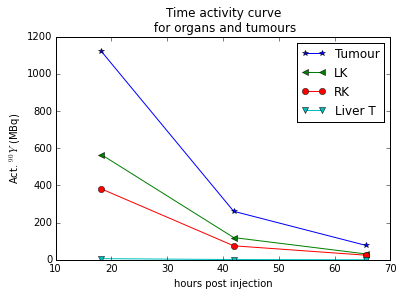

In [8]:
import matplotlib.pyplot as plt

plt.plot(data_T['pi_time_h'],data_T['Act_MBq_Y-90'],'*-', data_T['pi_time_h'], data_LK['Act_MBq_Y-90'],'<-',
        data_T['pi_time_h'], data_RK['Act_MBq_Y-90'],'o-',data_T['pi_time_h'], data_Liver_T['Act_MBq_Y-90'],'v-')

plt.legend(['Tumour','LK','RK','Liver T'])
plt.xlabel('hours post injection')
plt.ylabel('Act. $^{90}Y$ (MBq)')
plt.title('Time activity curve \n for organs and tumours')

Next step would be to adjust data with a mono-exponential model. `scipy` library offers `curve_fit` function to do so.
Once done, we could compute the cumulated activity.

In [9]:
# mono-exponential function
def monoexpo(x, a, b):
    return a*np.exp(-np.log(2)*x/b)

from scipy.optimize import curve_fit

fit_mono, fit_cov_mono = curve_fit(monoexpo, data_T.pi_time_h,
                                       data_T['Act_MBq_Y-90'],
                                       p0=(data_T['Act_MBq_Y-90'].iloc[0],T_Phys_Y90_h))
cumulated_activity = fit_mono[0]*fit_mono[1]/np.log(2)

`Y90_SFactor.txt` contains tabulated S factors for different spherical masses and values are presented in following graph.

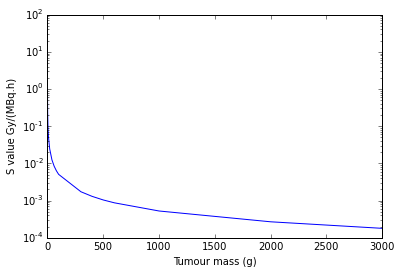

In [10]:
Sfactor = pd.read_csv('./Y90_SFactor.txt', delimiter='\t')
plt.plot(Sfactor['Tumour mass(g)'],Sfactor['S value Gy/(MBq.h)'])
plt.yscale('log')
plt.xlabel('Tumour mass (g)')
plt.ylabel('S value Gy/(MBq.h)')

We could interpolate the S factor value for the mass of the volume of interest and hence we are able to calculate the absorbed dose.

In [11]:
sfactor_T = np.interp(data_T['Volume cc'].iloc[0], Sfactor['Tumour mass(g)'], Sfactor['S value Gy/(MBq.h)'])
dose_T_Gy = sfactor_T*cumulated_activity
print "abs. dose:  {0:.2f} Gy".format(dose_T_Gy)

abs. dose:  244.70 Gy


## Biological equivalent dose
----

In addition, we will now explore the relation between the absorbed doses calculated and radiobiological parameters

Biologically Effective Dose

An expression for BED for molecular radiotherapy is :
$$ BED = D \left( 1 + \frac{D \lambda}{(\mu+\lambda)(\frac{\alpha}{\beta})} \right )$$

 

Where D is the total physical absorbed dose, λ is the effective decay constant of TRT dose rate, assuming mono-exponential decay, μ is the constant of repair of sublethal damage, and α and β are tissue specific parameters.  


In [61]:
from ipywidgets import interact, interactive
def calcul_bed(alpha_beta=10, repair=1, periode=10):
    coef = (dose_T_Gy * (np.log(2)/periode))/(((np.log(2)/periode) \
                                                    + (np.log(2)/repair))*alpha_beta)
    return dose_T_Gy * (1 + coef)
    
repair_hlf_h = 1
radio_sensitivity_fraction = 10
effective_hlf_h = fit_mono[1]
interact(calcul_bed,alpha_beta=(1,10), repair = (0.01,5,0.2),periode=np.round(fit_mono[1],2))
print "BED:  {0:.2f} Gy".format(calcul_bed(radio_sensitivity_fraction, repair_hlf_h, effective_hlf_h))

724.48041211142879

BED:  724.65 Gy
